# Optical Character Recognition (OCR) with OpenVINO™

This tutorial demonstrates how to perform optical character recognition (OCR) with OpenVINO models. It is a continuation of the [004-hello-detection](../004-hello-detection/004-hello-detection.ipynb) tutorial, which shows only text detection.

The [horizontal-text-detection-0001](https://docs.openvino.ai/2023.0/omz_models_model_horizontal_text_detection_0001.html) and [text-recognition-resnet](https://docs.openvino.ai/2023.0/omz_models_model_text_recognition_resnet_fc.html) models are used together for text detection and then text recognition.

In this tutorial, Open Model Zoo tools including Model Downloader, Model Converter and Info Dumper are used to download and convert the models from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo). For more information, refer to the [104-model-tools](../104-model-tools/104-model-tools.ipynb) tutorial.

#### Table of contents:
- [Imports](#Imports)
- [Settings](#Settings)
- [Download Models](#Download-Models)
- [Convert Models](#Convert-Models)
- [Select inference device](#Select-inference-device)
- [Object Detection](#Object-Detection)
    - [Load a Detection Model](#Load-a-Detection-Model)
    - [Load an Image](#Load-an-Image)
    - [Do Inference](#Do-Inference)
    - [Get Detection Results](#Get-Detection-Results)
- [Text Recognition](#Text-Recognition)
    - [Load Text Recognition Model](#Load-Text-Recognition-Model)
    - [Do Inference](#Do-Inference)
- [Show Results](#Show-Results)
    - [Show Detected Text Boxes and OCR Results for the Image](#Show-Detected-Text-Boxes-and-OCR-Results-for-the-Image)
    - [Show the OCR Result per Bounding Box](#Show-the-OCR-Result-per-Bounding-Box)
    - [Print Annotations in Plain Text Format](#Print-Annotations-in-Plain-Text-Format)


In [1]:
# Install openvino-dev package
%pip install -q "openvino-dev>=2023.1.0"  onnx

Note: you may need to restart the kernel to use updated packages.


## Imports
[back to top ⬆️](#Table-of-contents:)


In [2]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
from IPython.display import Markdown, display
from PIL import Image

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)
from notebook_utils import load_image

## Settings
[back to top ⬆️](#Table-of-contents:)


In [3]:
core = ov.Core()

model_dir = Path("model")
precision = "FP16"
detection_model = "horizontal-text-detection-0001"
recognition_model = "text-recognition-resnet-fc"

model_dir.mkdir(exist_ok=True)

## Download Models
[back to top ⬆️](#Table-of-contents:)

The next cells will run Model Downloader to download the detection and recognition models. If the models have been downloaded before, they will not be downloaded again.

In [4]:
download_command = f"omz_downloader --name {detection_model},{recognition_model} --output_dir {model_dir} --cache_dir {model_dir} --precision {precision}  --num_attempts 5"
display(Markdown(f"Download command: `{download_command}`"))
display(Markdown(f"Downloading {detection_model}, {recognition_model}..."))
!$download_command
display(Markdown(f"Finished downloading {detection_model}, {recognition_model}."))

detection_model_path = (model_dir / "intel/horizontal-text-detection-0001" / precision / detection_model).with_suffix(".xml")
recognition_model_path = (model_dir / "public/text-recognition-resnet-fc" / precision / recognition_model).with_suffix(".xml")

Download command: `omz_downloader --name horizontal-text-detection-0001,text-recognition-resnet-fc --output_dir model --cache_dir model --precision FP16  --num_attempts 5`

Downloading horizontal-text-detection-0001, text-recognition-resnet-fc...

################|| Downloading horizontal-text-detection-0001 ||################

========== Downloading model/intel/horizontal-text-detection-0001/FP16/horizontal-text-detection-0001.xml
... 100%, 815 KB, 676 KB/s, 1 seconds passed

========== Downloading model/intel/horizontal-text-detection-0001/FP16/horizontal-text-detection-0001.bin
... 100%, 3786 KB, 2032 KB/s, 1 seconds passed

################|| Downloading text-recognition-resnet-fc ||################

========== Downloading model/public/text-recognition-resnet-fc/vedastr/models/__init__.py
... 100%, 0 KB, 298 KB/s, 0 seconds passed

========== Downloading model/public/text-recognition-resnet-fc/vedastr/models/builder.py
... 100%, 0 KB, 617 KB/s, 0 seconds passed

========== Downloading model/public/text-recognition-resnet-fc/vedastr/models/model.py
... 100%, 0 KB, 1965 KB/s, 0 seconds passed

========== Downloading model/public/text-recognition-resnet-fc/vedastr/models/weight_init.py
... 100%, 3 KB, 9339 KB/s, 0 seconds passe

Finished downloading horizontal-text-detection-0001, text-recognition-resnet-fc.

In [5]:
### The text-recognition-resnet-fc model consists of many files. All filenames are printed in
### the output of Model Downloader. Uncomment the next two lines to show this output.

# for line in download_result:
#    print(line)

## Convert Models
[back to top ⬆️](#Table-of-contents:)

The downloaded detection model is an Intel model, which is already in OpenVINO Intermediate Representation (OpenVINO IR) format. The text recognition model is a public model which needs to be converted to OpenVINO IR. Since this model was downloaded from Open Model Zoo, use Model Converter to convert the model to OpenVINO IR format.

The output of Model Converter will be displayed. When the conversion is successful, the last lines of output will include `[ SUCCESS ] Generated IR version 11 model.`

In [6]:
convert_command = f"omz_converter --name {recognition_model} --precisions {precision} --download_dir {model_dir} --output_dir {model_dir}"
display(Markdown(f"Convert command: `{convert_command}`"))
display(Markdown(f"Converting {recognition_model}..."))
! $convert_command

Convert command: `omz_converter --name text-recognition-resnet-fc --precisions FP16 --download_dir model --output_dir model`

Converting text-recognition-resnet-fc...

========== Converting text-recognition-resnet-fc to ONNX
Conversion to ONNX command: /home/hong/openvino/.openvino_env/bin/python3 -- /home/hong/openvino/.openvino_env/lib/python3.10/site-packages/openvino/model_zoo/internal_scripts/pytorch_to_onnx.py --model-path=/home/hong/openvino/.openvino_env/lib/python3.10/site-packages/openvino/model_zoo/models/public/text-recognition-resnet-fc --model-path=model/public/text-recognition-resnet-fc --model-name=get_model --import-module=model '--model-param=file_config=r"model/public/text-recognition-resnet-fc/vedastr/configs/resnet_fc.py"' '--model-param=weights=r"model/public/text-recognition-resnet-fc/vedastr/ckpt/resnet_fc.pth"' --input-shape=1,1,32,100 --input-names=input --output-names=output --output-file=model/public/text-recognition-resnet-fc/resnet_fc.onnx

ONNX check passed successfully.

========== Converting text-recognition-resnet-fc to IR (FP16)
Conversion command: /home/hong/openvino/.openvino_env/bin/python3 -- /home/hong/openvino

## Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [7]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

## Object Detection
[back to top ⬆️](#Table-of-contents:)

Load a detection model, load an image, do inference and get the detection inference result.

### Load a Detection Model
[back to top ⬆️](#Table-of-contents:)


In [8]:
detection_model = core.read_model(
    model=detection_model_path, weights=detection_model_path.with_suffix(".bin")
)
detection_compiled_model = core.compile_model(model=detection_model, device_name=device.value)

detection_input_layer = detection_compiled_model.input(0)

### Load an Image
[back to top ⬆️](#Table-of-contents:)


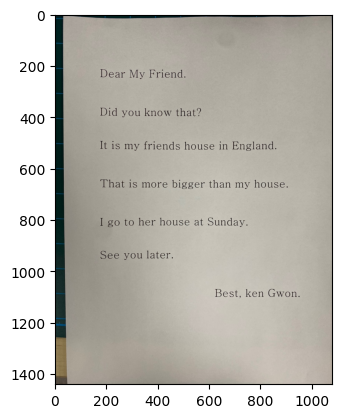

In [9]:
"""
# The `image_file` variable can point to a URL or a local image.
image_file = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/intel_rnb.jpg"

image = load_image(image_file)
"""
image = cv2.imread("sample_letter.jpg")


# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = detection_input_layer.shape

# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

### Do Inference
[back to top ⬆️](#Table-of-contents:)

Text boxes are detected in the images and returned as blobs of data in the shape of `[100, 5]`. Each description of detection has the `[x_min, y_min, x_max, y_max, conf]` format.

In [10]:
output_key = detection_compiled_model.output("boxes")
boxes = detection_compiled_model([input_image])[output_key]

# Remove zero only boxes.
boxes = boxes[~np.all(boxes == 0, axis=1)]

### Get Detection Results
[back to top ⬆️](#Table-of-contents:)


In [11]:
def multiply_by_ratio(ratio_x, ratio_y, box):
    return [
        max(shape * ratio_y, 10) if idx % 2 else shape * ratio_x
        for idx, shape in enumerate(box[:-1])
    ]


def run_preprocesing_on_crop(crop, net_shape):
    temp_img = cv2.resize(crop, net_shape)
    temp_img = temp_img.reshape((1,) * 2 + temp_img.shape)
    return temp_img


def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0), "white": (255, 255, 255)}

    # Fetch image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box, annotation in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply position of each box by x and y ratio.
            (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, box))

            # Draw a box based on the position. Parameters in the `rectangle` function are: image, start_point, end_point, color, thickness.
            cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add a text to an image based on the position and confidence. Parameters in the `putText` function are: image, text, bottomleft_corner_textfield, font, font_scale, color, thickness, line_type
            if conf_labels:
                # Create a background box based on annotation length.
                (text_w, text_h), _ = cv2.getTextSize(
                    f"{annotation}", cv2.FONT_HERSHEY_TRIPLEX, 0.8, 1
                )
                image_copy = rgb_image.copy()
                cv2.rectangle(
                    image_copy,
                    (x_min, y_min - text_h - 10),
                    (x_min + text_w, y_min - 10),
                    colors["white"],
                    -1,
                )
                # Add weighted image copy with white boxes under a text.
                cv2.addWeighted(image_copy, 0.4, rgb_image, 0.6, 0, rgb_image)
                cv2.putText(
                    rgb_image,
                    f"{annotation}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

## Text Recognition
[back to top ⬆️](#Table-of-contents:)

Load the text recognition model and do inference on the detected boxes from the detection model.

### Load Text Recognition Model
[back to top ⬆️](#Table-of-contents:)


In [12]:
recognition_model = core.read_model(
    model=recognition_model_path, weights=recognition_model_path.with_suffix(".bin")
)

recognition_compiled_model = core.compile_model(model=recognition_model, device_name=device.value)

recognition_output_layer = recognition_compiled_model.output(0)
recognition_input_layer = recognition_compiled_model.input(0)

# Get the height and width of the input layer.
_, _, H, W = recognition_input_layer.shape

### Do Inference
[back to top ⬆️](#Table-of-contents:)


In [13]:
# Calculate scale for image resizing.
(real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

# Convert the image to grayscale for the text recognition model.
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Get a dictionary to encode output, based on the model documentation.
letters = "~0123456789abcdefghijklmnopqrstuvwxyz"

# Prepare an empty list for annotations.
annotations = list()
cropped_images = list()
# fig, ax = plt.subplots(len(boxes), 1, figsize=(5,15), sharex=True, sharey=True)
# Get annotations for each crop, based on boxes given by the detection model.
for i, crop in enumerate(boxes):
    # Get coordinates on corners of a crop.
    (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, crop))
    image_crop = run_preprocesing_on_crop(grayscale_image[y_min:y_max, x_min:x_max], (W, H))

    # Run inference with the recognition model.
    result = recognition_compiled_model([image_crop])[recognition_output_layer]

    # Squeeze the output to remove unnecessary dimension.
    recognition_results_test = np.squeeze(result)

    # Read an annotation based on probabilities from the output layer.
    annotation = list()
    for letter in recognition_results_test:
        parsed_letter = letters[letter.argmax()]

        # Returning 0 index from `argmax` signalizes an end of a string.
        if parsed_letter == letters[0]:
            break
        annotation.append(parsed_letter)
    annotations.append("".join(annotation))
    cropped_image = Image.fromarray(image[y_min:y_max, x_min:x_max])
    cropped_images.append(cropped_image)

boxes_with_annotations = list(zip(boxes, annotations))

## Show Results
[back to top ⬆️](#Table-of-contents:)

### Show Detected Text Boxes and OCR Results for the Image
[back to top ⬆️](#Table-of-contents:)

Visualize the result by drawing boxes around recognized text and showing the OCR result from the text recognition model.

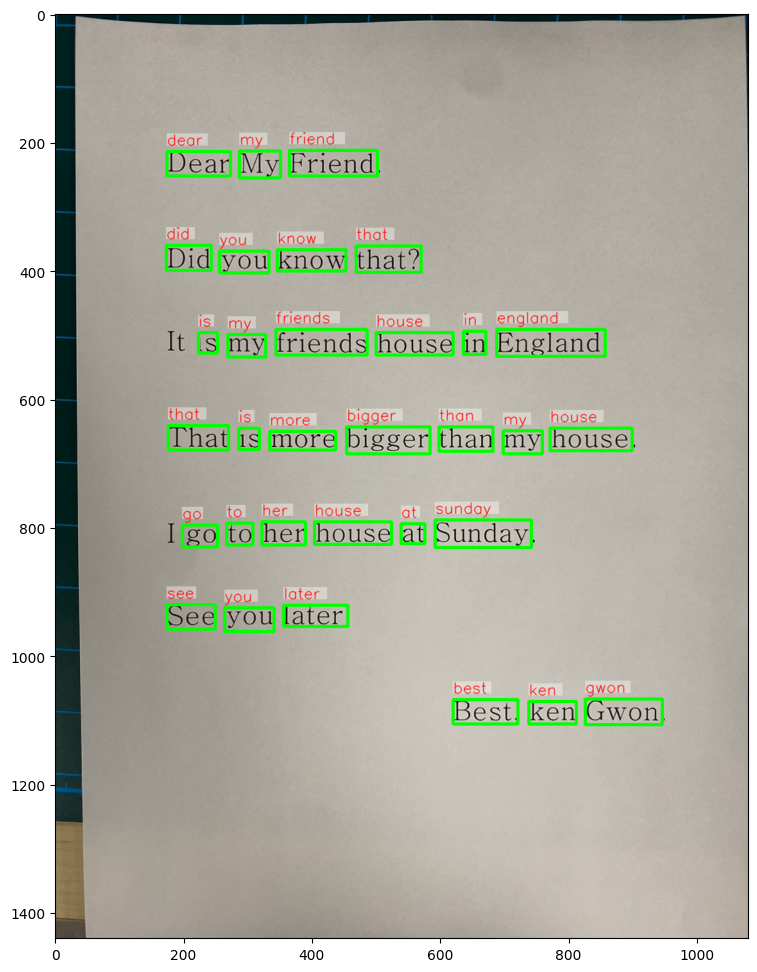

In [14]:
plt.figure(figsize=(12, 12))
plt.imshow(convert_result_to_image(image, resized_image, boxes_with_annotations, conf_labels=True));

### Show the OCR Result per Bounding Box
[back to top ⬆️](#Table-of-contents:)

Depending on the image, the OCR result may not be readable in the image with boxes, as displayed in the cell above. Use the code below to display the extracted boxes and the OCR result per box.

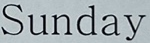

sunday

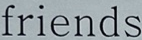

friends

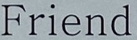

friend

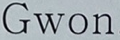

gwon

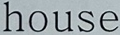

house

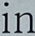

in

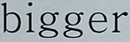

bigger

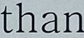

than

at

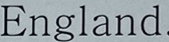

england

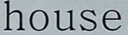

house

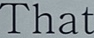

that

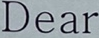

dear

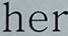

her

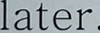

later

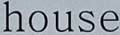

house

more

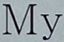

my

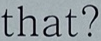

that

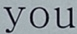

you

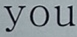

you

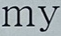

my

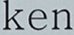

ken

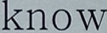

know

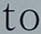

to

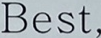

best

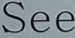

see

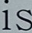

is

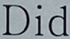

did

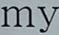

my

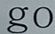

go

is

it

i

In [15]:
for cropped_image, annotation in zip(cropped_images, annotations):
    display(cropped_image, Markdown("".join(annotation)))

### Print Annotations in Plain Text Format
[back to top ⬆️](#Table-of-contents:)

Print annotations for detected text based on their position in the input image, starting from the upper left corner.


In [16]:
[
    annotation
    for _, annotation in sorted(zip(boxes, annotations), key=lambda x: x[0][0] ** 2 + x[0][1] ** 2)
]

['dear',
 'did',
 'my',
 'you',
 'friend',
 'it',
 'is',
 'know',
 'my',
 'friends',
 'that',
 'that',
 'is',
 'more',
 'i',
 'house',
 'go',
 'to',
 'bigger',
 'her',
 'see',
 'house',
 'in',
 'you',
 'than',
 'later',
 'england',
 'at',
 'sunday',
 'my',
 'house',
 'best',
 'ken',
 'gwon']